## Analyse exploratoire des données avec focus sur le dépassement budgétaire

# 1. Importation des bibliothèques

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# 2. Chargement de la base fusionnée

In [29]:

base = pd.read_csv("base.csv", on_bad_lines='skip')


## 3. Création des colonnes 'ecart' et 'depassement'
* Ecart = dépenses réelles - prévues
* Dépassement = 1 si écart > 0, sinon 0

In [30]:
base['depense'] = pd.to_numeric(base['depense'], errors='coerce')
base['type_depense'] = base['type_depense'].str.lower()

pivot = base.pivot_table(index=['id_action', 'annee_financiere'],
                         columns='type_depense',
                         values='depense',
                         aggfunc='sum').reset_index()
pivot = pivot.rename(columns={
    'dépenses prévues': 'depense_prevue',
    'dépenses réelles': 'depense_reelle'
})
pivot['ecart'] = pivot['depense_reelle'].fillna(0) - pivot['depense_prevue'].fillna(0) # Handle potential NaNs
pivot['depassement'] = pivot['ecart'].apply(lambda x: 1 if x > 0 else 0)

## Fusion avec des colonnes descriptives (gérer les doublons potentiels avant la fusion) Supprimer les lignes en double basées sur 'id_action' et 'annee_financiere' avant la fusion


In [31]:
base_unique_keys = base.drop_duplicates(subset=['id_action', 'annee_financiere'])
base = pd.merge(pivot, base_unique_keys.drop(columns=['depense', 'type_depense']), on=['id_action', 'annee_financiere'], how='left')

## 4. Valeurs manquantes

In [32]:
print("\n--- Valeurs manquantes ---")
print(base.isna().sum().sort_values(ascending=False))


--- Valeurs manquantes ---
depense_reelle                   492
reference_web                    329
commentaire_indicateur           280
resultats_obtenus_lancement      187
criteres_admissibilite           162
partenaires                      127
pourcentage_resultat             125
cible_indicateur                 115
annee_atteinte_cible             115
type_indicateur                  111
pourcentage_electrification      110
categorie_beneficiaire_action    109
action_merged                    109
resultat_comparaison_cible       105
id_indicateur                    105
action_indicateurs               105
id_cible                         105
indicateur                       105
unite_mesure                     105
processus_suivi                   68
date_fin                          51
resultats_attendus                30
date_debut                        21
action_actions                    11
resultats_obtenus_annee           11
objectif_pmo                      11
finalite  

## 5. Statistiques descriptives


--- Statistiques descriptives (variables numériques pertinentes) ---
       depense_prevue  depense_reelle         ecart  depassement  \
count    5.990000e+02    1.150000e+02  6.070000e+02   607.000000   
mean     2.609152e+08    3.005069e+08 -2.005435e+08     0.051071   
std      6.802939e+08    1.143179e+09  6.466271e+08     0.220324   
min      5.000000e+04    0.000000e+00 -4.562000e+09     0.000000   
25%      3.000000e+06    2.356015e+06 -7.500000e+07     0.000000   
50%      1.500000e+07    1.043621e+07 -9.973337e+06     0.000000   
75%      1.230474e+08    9.450456e+07 -1.675000e+06     0.000000   
max      5.780835e+09    9.734349e+09  5.598349e+09     1.000000   

       pourcentage_resultat  pourcentage_electrification  
count            482.000000                   497.000000  
mean               0.675490                     0.121660  
std                0.806557                     0.316437  
min                0.000000                     0.000000  
25%                0.0

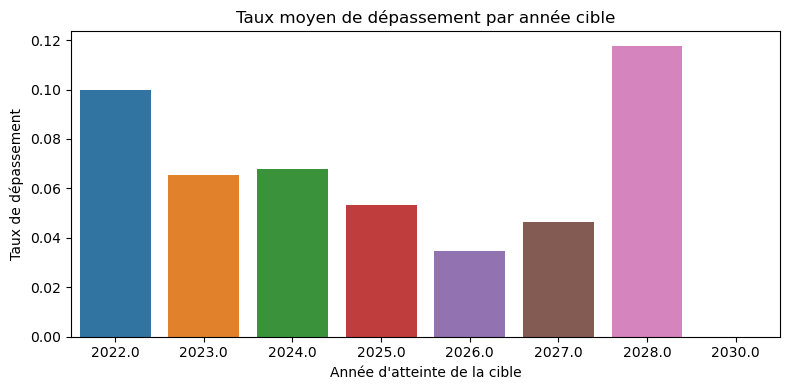

In [41]:
# Statistiques descriptives logiques : uniquement numériques pertinentes (sauf année cible)
numeric_cols = ['depense_prevue', 'depense_reelle', 'ecart', 'depassement', 'pourcentage_resultat', 'pourcentage_electrification']
print("\n--- Statistiques descriptives (variables numériques pertinentes) ---")
print(base[numeric_cols].describe())

#  Statistique logique : taux de dépassement par annee_atteinte_cible

if 'annee_atteinte_cible' in base.columns:
    print("\n--- Taux de dépassement par année d’atteinte de la cible ---")
    taux_par_annee = base.groupby('annee_atteinte_cible')['depassement'].mean().sort_index()
    print(taux_par_annee.round(3))

if 'annee_atteinte_cible' in base.columns:
    taux_par_annee = base.groupby('annee_atteinte_cible')['depassement'].mean().reset_index()
    plt.figure(figsize=(8, 4))
    sns.barplot(data=taux_par_annee, x='annee_atteinte_cible', y='depassement')
    plt.title("Taux moyen de dépassement par année cible")
    plt.xlabel("Année d'atteinte de la cible")
    plt.ylabel("Taux de dépassement")
    plt.tight_layout()
    plt.show()

## 6. Visualisation de la distribution des écarts

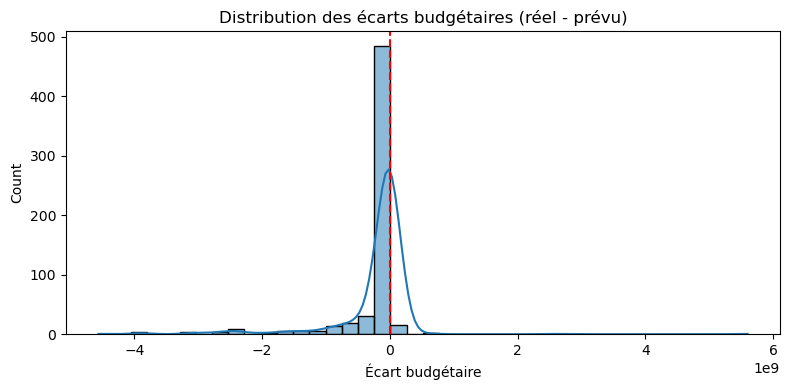

In [34]:
plt.figure(figsize=(8, 4))
sns.histplot(base['ecart'].dropna(), bins=40, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Distribution des écarts budgétaires (réel - prévu)")
plt.xlabel("Écart budgétaire")
plt.tight_layout()
plt.show()


## 7. Répartition des dépassements (binaire)

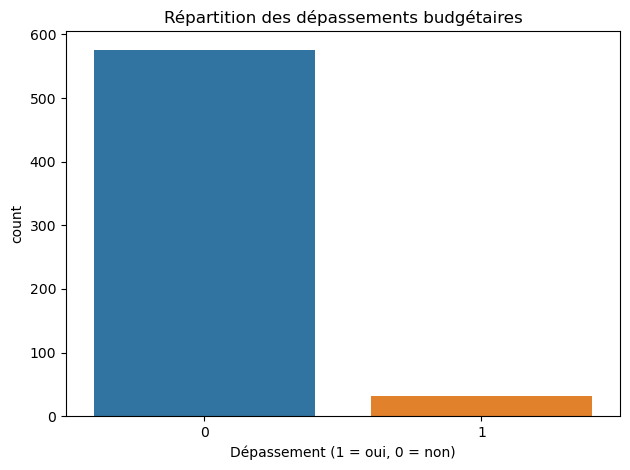

In [35]:
plt.figure() # Add a new figure for this plot
sns.countplot(x='depassement', data=base)
plt.title("Répartition des dépassements budgétaires")
plt.xlabel("Dépassement (1 = oui, 0 = non)")
plt.tight_layout()
plt.show()


## 8. Moyenne des écarts par ministère

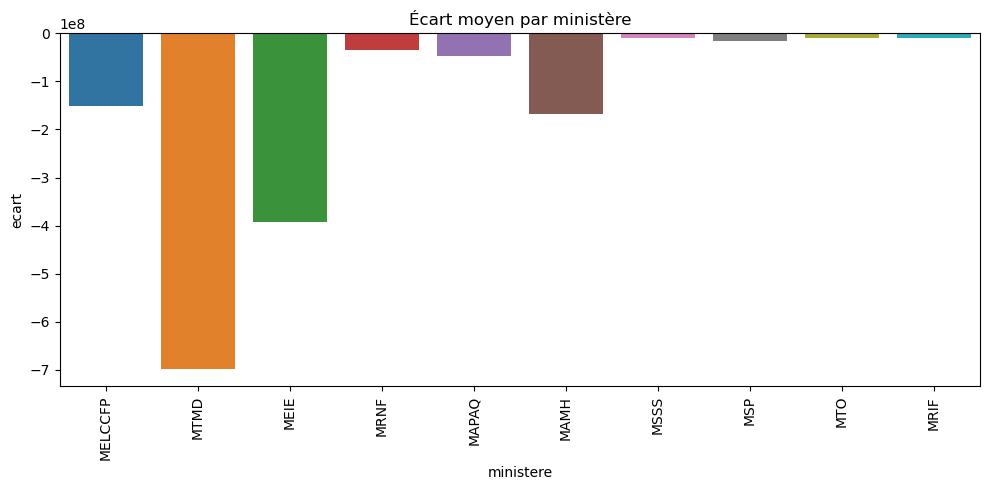

In [36]:
plt.figure(figsize=(10, 5))
sns.barplot(data=base, x='ministere', y='ecart', errorbar=None)
plt.xticks(rotation=90)
plt.title("Écart moyen par ministère")
plt.tight_layout()
plt.show()

## 9. Moyenne des écarts par finalité

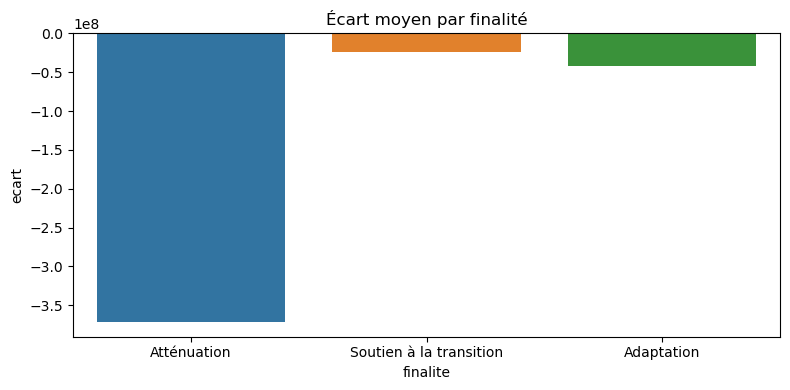

In [37]:
plt.figure(figsize=(8, 4))
sns.barplot(data=base, x='finalite', y='ecart', errorbar=None)
plt.title("Écart moyen par finalité")
plt.tight_layout()
plt.show()


## 10. Corrélations avec la variable 'depassement'*# Sélectionner uniquement les colonnes numériques pour le calcul des corrélations


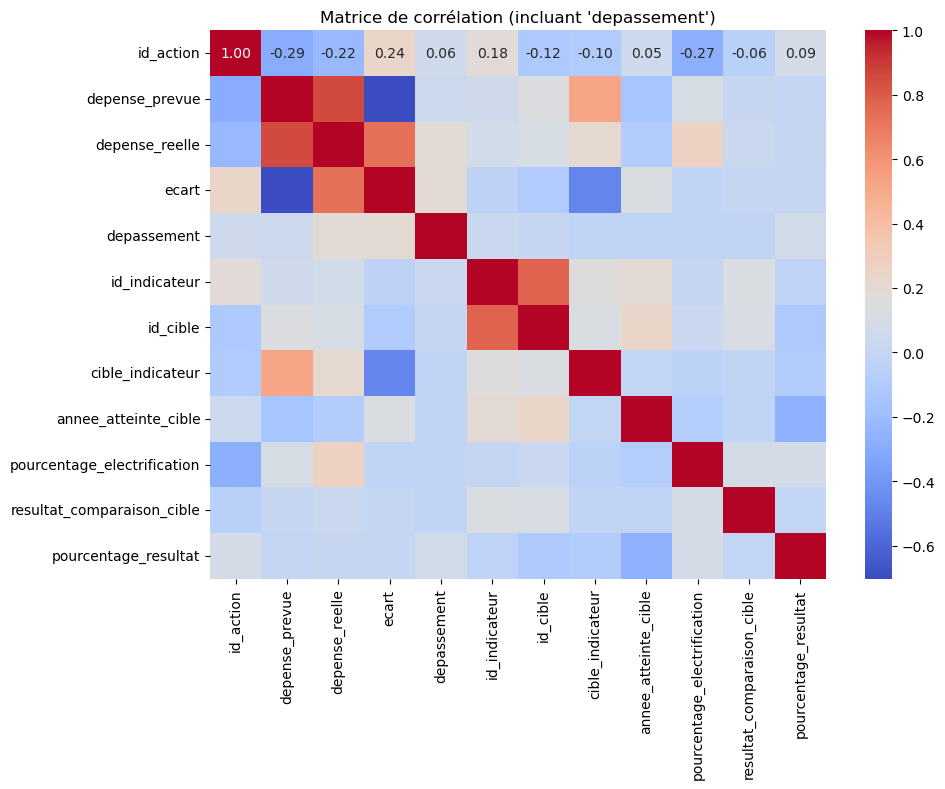

In [38]:
numeric_cols = base.select_dtypes(include=['float64', 'int64']).columns
corrs = base[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corrs, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matrice de corrélation (incluant 'depassement')")
plt.tight_layout()
plt.show()

## 11. Export du fichier EDA (avec écart et dépassement)

In [39]:
base.to_csv("eda.csv", index=False)
print("\n✅ Fichier eda.csv enregistré avec les colonnes 'ecart' et 'depassement'.")


✅ Fichier eda.csv enregistré avec les colonnes 'ecart' et 'depassement'.
